# Symbolic regression with filtered GP-NLS (FGP-NLS).
Date: 2022/09/01 <br>
Authors: Takaki Katsushi, Tomoyuki Miyao

Three filters can be introduced to GP-NLS: Variable filter (V-filter), Functional filter (F-filter) and Domain filter (D-filter). GP-NLS and FGP-NLS are implemented on top of the [Deap](https://deap.readthedocs.io/en/master/index.htmlhttps://deap.readthedocs.io/en/master/index.html) GP library.

This tutorial explains how the FGP-NLS library is used for simple quantitative structure-property regression models. The data sets were a part of our benchmark calculation reported in the publication [Reference]() .

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from FGP_NLS.deap_based_FGP_NLS import Symbolic_Reg

## Loading data set
QED and SA_score are the prediction targets. Randomly sampled 5000 ZINC compounds forms the data set. The 34 descriptors were chemical structural descriptors calculated by [RDKit](https://www.rdkit.org/docs/index.html) modules.

In [2]:
df = pd.read_csv('./data/000_data.tsv', sep='\t', index_col=0)
print(f'Data set shape: {df.shape}')
df.head()

Data set shape: (5000, 39)


,EMWt,FCSP3,HAtmCount,HAtmMWt,LASA,MaxAbsESI,MaxAbsPC,MaxESI,MaxPC,MinAbsESI,...,NSHc,NSR,NVE,RCount,TPSA,logp,nonstereo_aromatic_smiles,zinc_id,QED,SA_score
169906,352.135782,0.210526,25,332.303,151.031678,12.149769,0.325366,12.149769,0.234352,0.066213,...,0,0,128,3,59.81,3.923,Cc1ccc(cc1C)n2c(nnc2SCC(=O)Nc3ccccc3)C,ZINC000409108081,0.707093,1.924610
290287,239.132157,0.461538,17,221.146,100.976463,12.696282,0.480624,12.696282,0.260563,0.126227,...,0,0,94,1,38.33,2.509,CCCNC(=O)C(CC)Oc1ccc(cc1)F,ZINC000020457347,0.827960,2.245329
637156,282.103813,0.538462,19,264.221,116.260230,11.799428,0.464205,11.799428,0.281234,0.063655,...,1,1,104,2,62.55,2.324,Cc1ccc(o1)C(C)NC(=O)CCN2CCSC2=O,ZINC000065447550,0.899981,2.943226
838729,442.192628,0.458333,31,412.341,184.201680,13.059464,0.381382,13.059464,0.242588,0.060408,...,2,2,166,4,75.71,2.952,c1ccc(cc1)C2(CCOCC2)CNC(=O)C3CCCN(C3)S(=O)(=O)...,ZINC000225517187,0.746397,2.741864
329934,456.163140,0.304348,32,431.343,186.464060,13.409528,0.325852,13.409528,0.246254,0.182487,...,1,1,168,4,84.30,3.668,Cc1c(c(n(n1)c2ccccc2)C)S(=O)(=O)N3CCC(CC3)C(=O...,ZINC000085642623,0.635012,2.161683


## Splitting data set into training and test. 
Let X be the descriptor and y be a prediction target: QED.

In [3]:
X = df.loc[:, 'EMWt':'logp']
y = df.loc[:, 'QED']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, random_state=0)

print(f'X train size: {X_train.shape}, X test size: {X_test.size}')

X train size: (100, 35), X test size: 171500


## Parameters for symbolic regression

population_size (int, optional): [description]. Defaults to 1000.  
The number of formulas to search per generation.  

generations (int, optional): [description]. Defaults to 200.  
The number of generations to repeat.  

tournament_size (int, optional): [description]. Defaults to 5.  
The number of candidates selected from the population. The best is selected from among them.  

num_elite_select (int, optional): [description]. Defaults to 1.  
The number of formulas that are always saved based on precision.  

max_depth (int, optional): [description]. Defaults to 4.  
Maximum depth of an individual. The higher the value, the higher the accuracy, but the calculation may take longer.  

function_set (list, optional): [description]. Defaults to ['add', 'sub', 'mul', 'div', 'ln', 'log', 'sqrt'].  
Operator to use in formulas.  

metric (str, optional): [description]. Defaults to 'mae'.  
Evaluation index.

p_crossover (float, optional): [description]. Defaults to 0.7.  
Probability of crossover. Crossover is an operation that exchanges parts of mathematical expressions.  

p_mutation (float, optional): [description]. Defaults to 0.2.  
Mutation Establishment. Mutation replaces part of the formula with a randomly generated formula.  

random_state (int, optional): [description]. Defaults to 0.  

const_range (tuple, optional): [description]. Defaults to (0, 1).  
A range of randomly generated constants. Optimized with this value as the initial value.  

x_domain ([type], optional): [description]. Defaults to None.  
The expected X range.  

y_domain ([type], optional): [description]. Defaults to None.  
The expected y range.  

results_dir (str, optional): [description]. Defaults to './results'.  
Specify where to save the results.  
Save with "Symbolic_Reg.save_all()".

## FGP-NLS model construction (three filters are on)
```
   function_filter = True
   variable_filter = True
   xydomain_filter = True
``` 


In [4]:
result_dir = './result2'

est = Symbolic_Reg( population_size=200,
                    generations=100,
                    tournament_size=5,
                    num_elite_select = 1,
                    max_depth=4,
                    function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'square', 'cube', 'ln', 'exp'),
                    metric='rmse', 
                    p_crossover=0.7, 
                    p_mutation=0.2, 
                    random_state=0,
                    x_domain=X,
                    y_domain=(0, 1),
                    var_max_trial=5000,
                    function_filter = True, 
                    variable_filter = True, 
                    xydomain_filter = True,
                    constonly_filter= True,
                    domain_equal    = (True, True),
                    results_dir=result_dir)

# traininig
est.fit(X_train, y_train)

# save the training results
est.save_all()

  Gen  ! -- score-min -- ! -- score-med -- ! -- score-max -- ! -- score-std -- ! -- unique_rate -- ! -- nevals -- 
-------!-----------------!-----------------!-----------------!-----------------!-------------------!--------------
    0  !          0.17   !          0.67   !          0.68   !          0.16   !            1.00   !   2.00e+02   
    1  !          0.17   !           inf   !           inf   !          0.18   !            0.69   !   1.44e+02   
    2  !          0.17   !           inf   !           inf   !          0.18   !            0.73   !   1.59e+02   
    3  !          0.17   !           inf   !           inf   !          0.19   !            0.68   !   1.47e+02   
    4  !          0.17   !           inf   !           inf   !          0.17   !            0.70   !   1.54e+02   
    5  !          0.16   !           inf   !           inf   !          0.13   !            0.63   !   1.43e+02   
    6  !          0.16   !           inf   !           inf   !          0.14   !

## Prediction of the QED values for training and test data sets

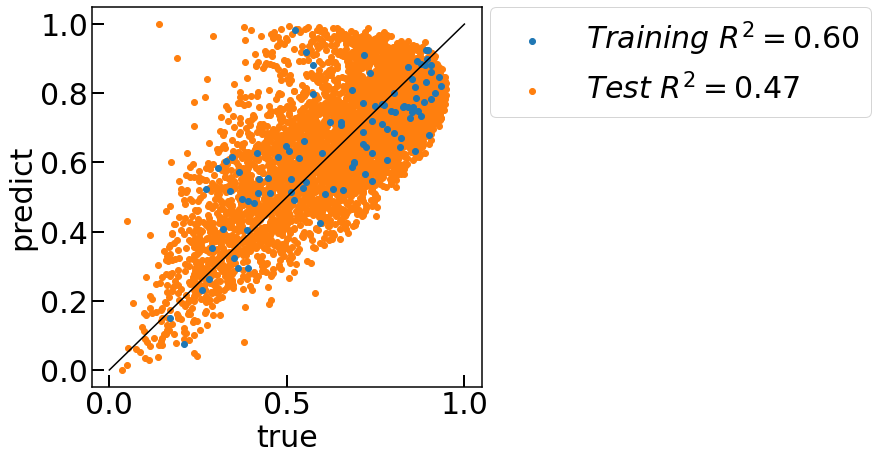

In [5]:
y_train_pred = est.predict(X_train)
y_test_pred  = est.predict(X_test)

# Evaluation
r2_train = r2_score(y_true=y_train, y_pred=y_train_pred)
r2_test  = r2_score(y_true=y_test,  y_pred=y_test_pred)

# YY plots 
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlabel('true'); ax.set_ylabel('predict')
ax.plot([0, 1], [0, 1], c='k')
ax.scatter(y_train, y_train_pred,  label=f'$Training\ R^2 = {r2_train:.2f}$')
ax.scatter(y_test, y_test_pred,    label=f'$Test\ R^2 = {r2_test:.2f}$', zorder=-1)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

## Looking at output files 
FGP-NLS models were saved in the directory specified in the `results_dir` argument when creating`Symbolic_Reg` instance.  

1. Files with the prefix of **001_GP_log** store RMSE values (fitness scores) during generation.  
2. Files with the prefix of **001_GP_node** show node profiles during generation.  
3. Files with the prefix of **002_best** contain the information of best formula.

In [8]:
result_files = glob.glob(f'{result_dir}/*')

print('Result file contents')
result_files

Result file contents


['./result2\\000_GP_log_txt.txt',
 './result2\\001_FilterGPSR_params.tsv',
 './result2\\001_GP_log.tsv',
 './result2\\001_GP_log_min_pl.png',
 './result2\\001_GP_log_pl.png',
 './result2\\001_GP_log_std_pl.png',
 './result2\\001_GP_log_unique_rate_pl.png',
 './result2\\001_GP_node_analysis.tsv',
 './result2\\001_GP_node_analysis_func_all_pl.png',
 './result2\\001_GP_node_analysis_func_all_select_pl.png',
 './result2\\001_GP_node_analysis_func_pl.png',
 './result2\\001_GP_node_analysis_func_select_pl.png',
 './result2\\001_GP_node_analysis_select.tsv',
 './result2\\001_GP_node_analysis_X_pl.png',
 './result2\\001_GP_node_analysis_X_select_pl.png',
 './result2\\002_best_expr4word.txt',
 './result2\\002_best_expr4word_3digits.txt',
 './result2\\002_best_expr4word_3digits_non_e.txt',
 './result2\\002_best_expr4word_non_e.txt',
 './result2\\002_best_model.tex',
 './result2\\002_best_model_expr.png']

### Showing RMSE values during generation.
Now, we can see that the how fitness values (RMSE) changed during evolution.

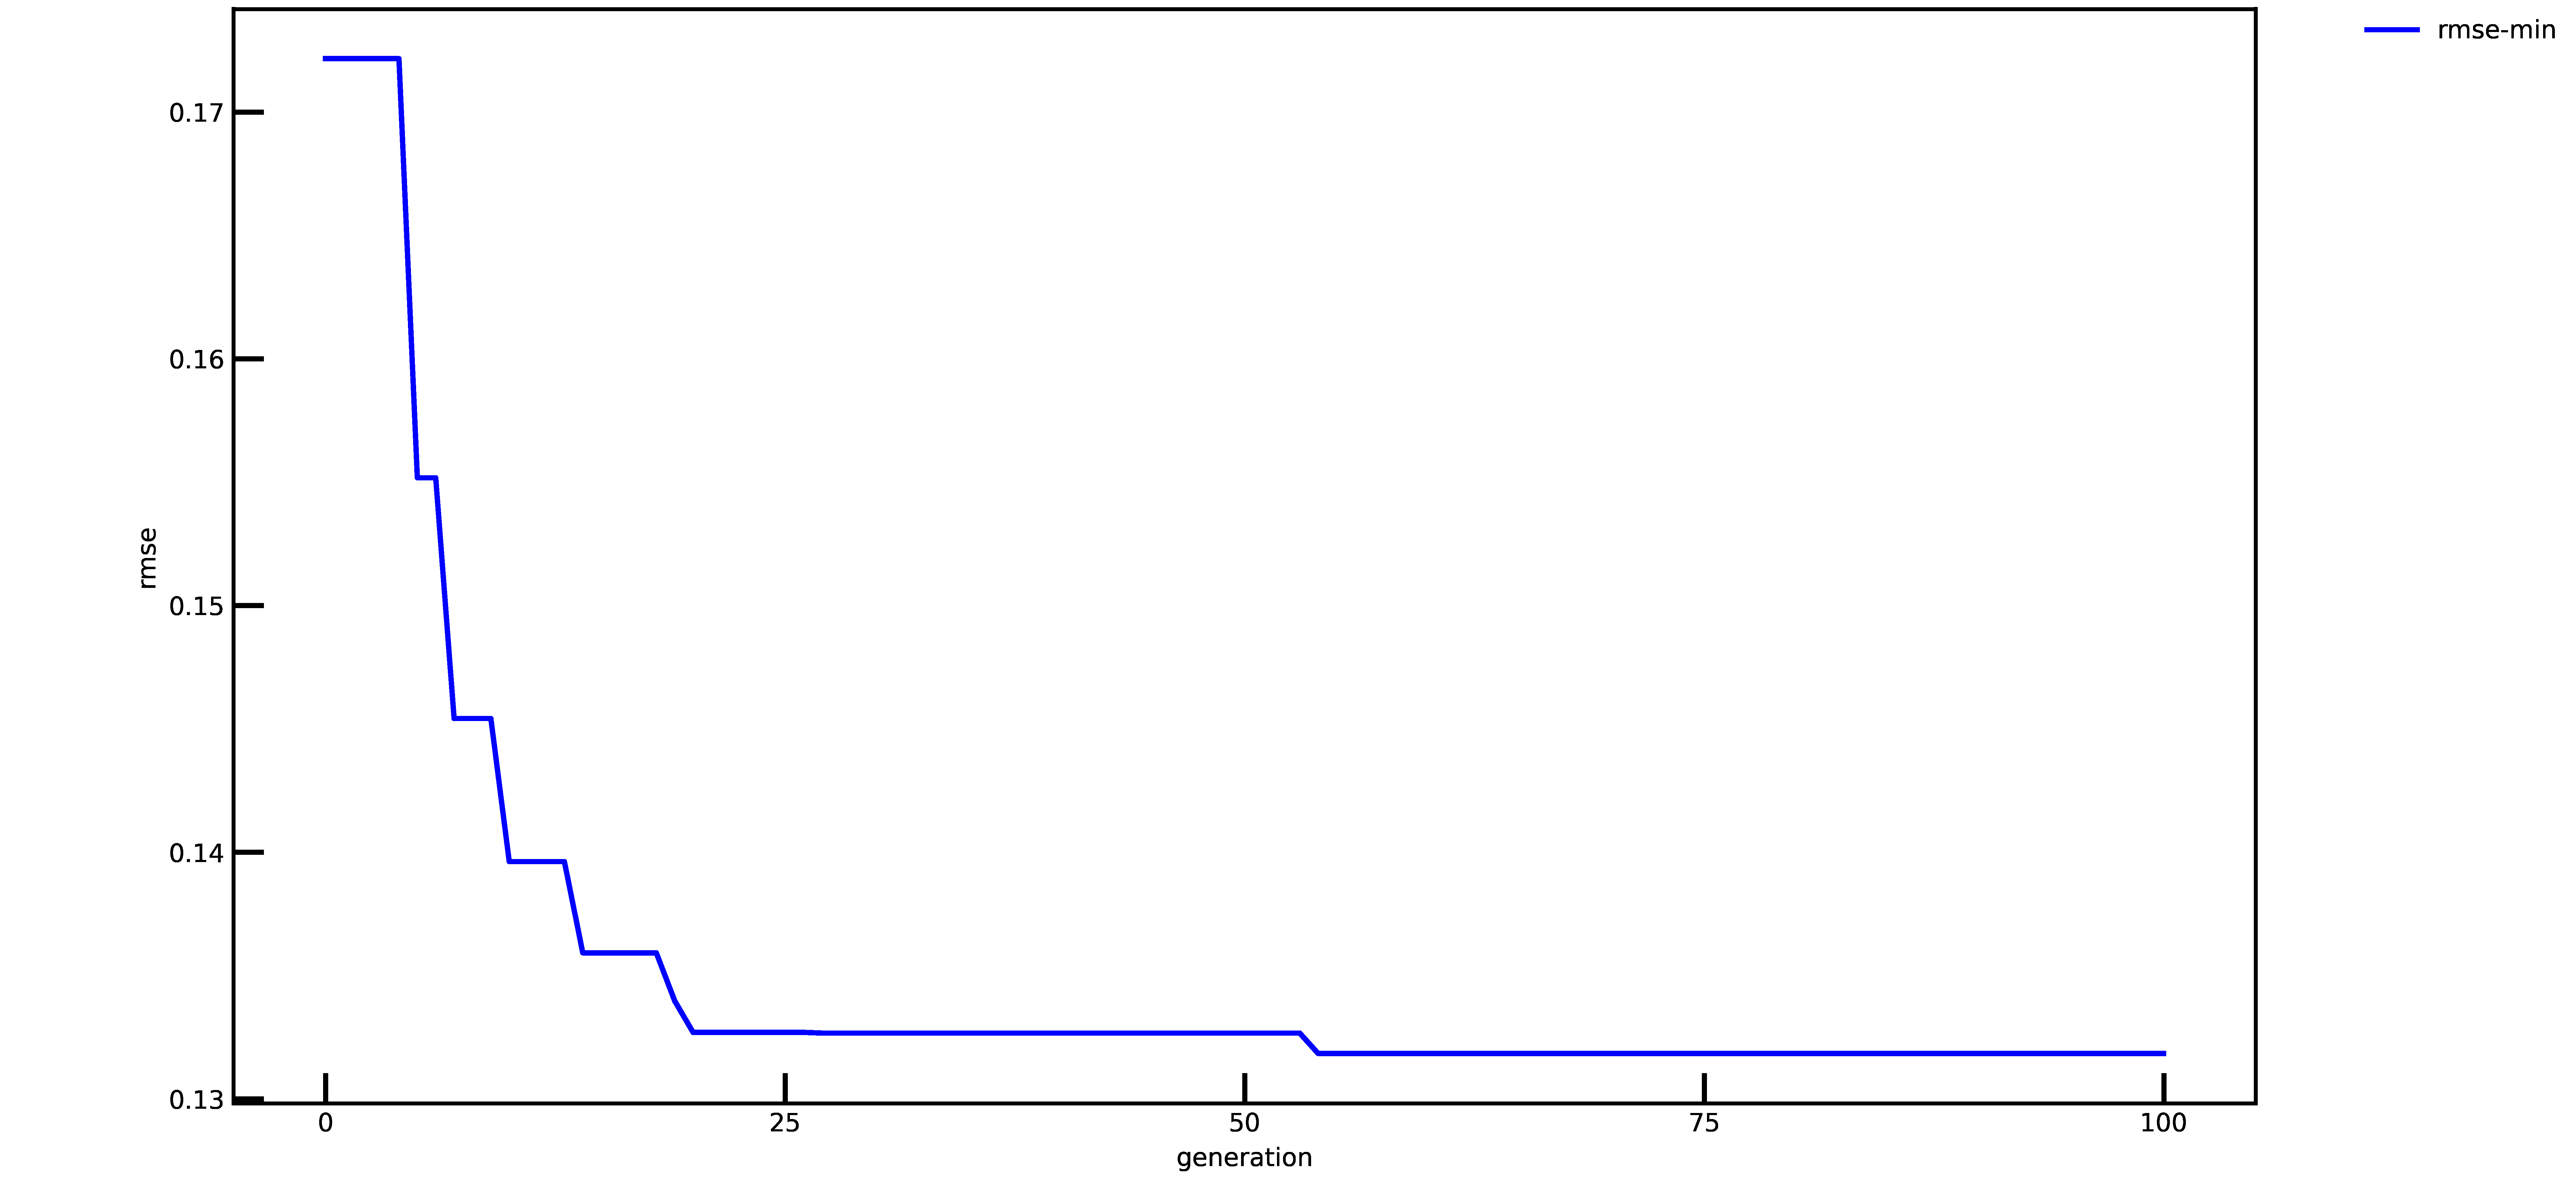

In [9]:
Image.open(f'{result_dir}/001_GP_log_min_pl.png').convert('RGB')

### Showing operator profiles during generation.
The below lines show the proportion of indivisuals containing specific operations.

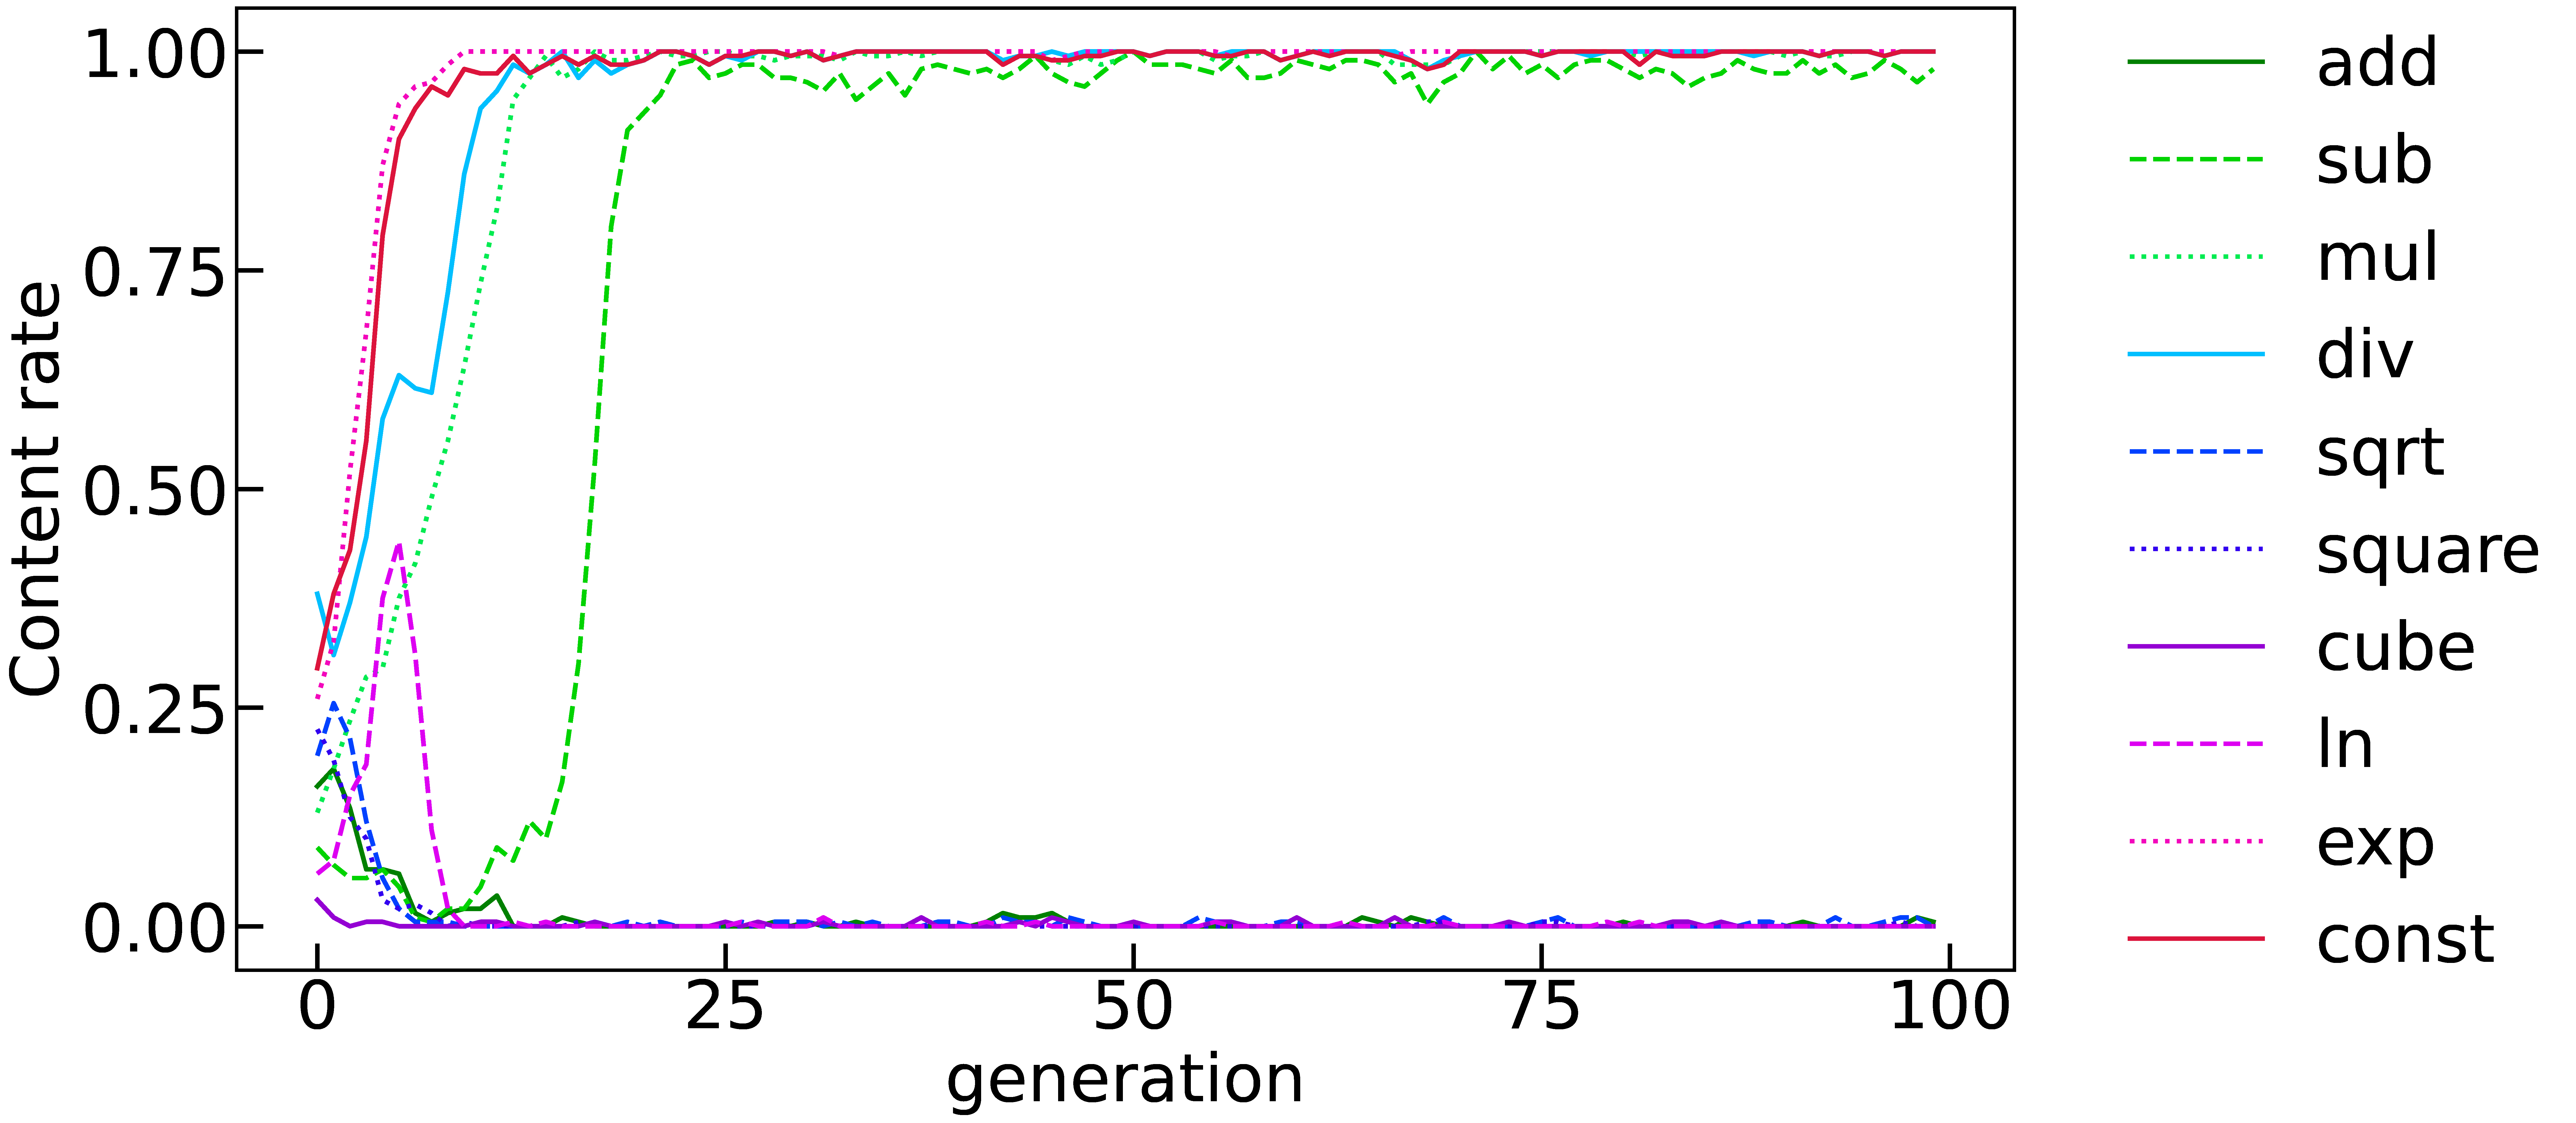

In [10]:
Image.open(f'{result_dir}/001_GP_node_analysis_func_select_pl.png').convert('RGB')

### Showing descriptor profiles during generation.
The below lines show the proportion of indivisuals containing specific descriptors.

In [11]:
Image.open(f'{result_dir}/001_GP_node_analysis_X_select_pl.png').convert('RGB')

### Showing best expression.
The selected formula is saved as an image.  
It may be different from the best stored formula for the last generation of "000_GP_log_txt.txt", but it has been simplified by the Sympy library.

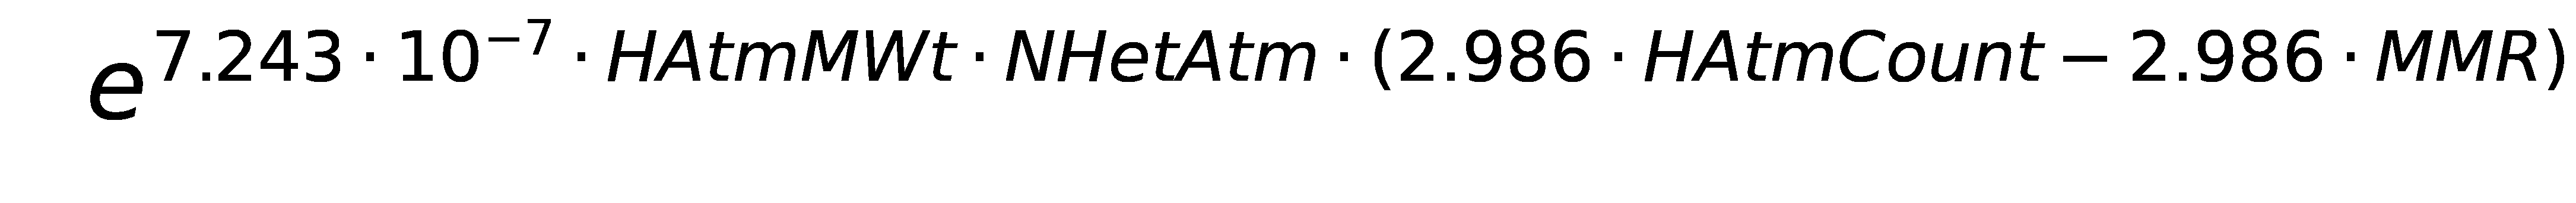

In [12]:
Image.open(f'{result_dir}/002_best_model_expr.png').convert('RGB')

### Log file contents
`After selection` is the formula selected from the previous generation.   
`After evolution` is a mathematical formula evolved by crossing and so on.   
`After const opt` is a constant optimized formula.  

example  
'After selection : formula  (score)

In [13]:
f = open(f'{result_dir}/000_GP_log_txt.txt')
lines = f.readlines()[:50]
f.close()
lines

[' 200 [ ind ] / 6442 [ trials ] (time : 0.060 min)\n',
 '\n',
 '=============== gen 0 ===============\n',
 'ind 0 : cube(NRE)\n',
 'ind 1 : sqrt(MinAbsPC)\n',
 'ind 2 : square(NRE)\n',
 'ind 3 : square(div(FCSP3, EMWt))\n',
 'ind 4 : square(MaxAbsPC)\n',
 'ind 5 : square(FCSP3)\n',
 'ind 6 : div(NSCc, EMWt)\n',
 'ind 7 : square(MaxPC)\n',
 'ind 8 : div(NSCc, MMR)\n',
 'ind 9 : exp(cube(MinPC))\n',
 'ind 10 : div(NAliHc, EMWt)\n',
 'ind 11 : cube(MaxAbsPC)\n',
 'ind 12 : sqrt(FCSP3)\n',
 'ind 13 : mul(sqrt(NAliR), mul(NAroHc, NRE))\n',
 'ind 14 : add(MinAbsPC, 0.38597629067)\n',
 'ind 15 : exp(mul(MinPC, NAroR))\n',
 'ind 16 : mul(div(NAroR, MWt), mul(NRE, NSHc))\n',
 'ind 17 : exp(NRE)\n',
 'ind 18 : square(div(NRB, HAtmMWt))\n',
 'ind 19 : div(HAtmCount, EMWt)\n',
 'ind 20 : div(NRE, EMWt)\n',
 'ind 21 : div(NRE, MinAbsPC)\n',
 'ind 22 : cube(MinAbsPC)\n',
 'ind 23 : div(NRE, add(HAtmMWt, NHetAtm))\n',
 'ind 24 : square(MinPC)\n',
 'ind 25 : mul(NRE, NHOHCount)\n',
 'ind 26 : exp(Min